# Implementing depp neural network (dnn) from scratch

### How Neural Networks works.

Deep neural networks contains multiple layes of functions/operator from input to output. There will be one input layes, one output layer and one or more hidden layer. Each layer translates its input matrix X to output matrix Y with a linear/non-linear transformation. 

![Deep Neural Network](images/deep_nn.png "Deep Neural Network")

Most common transformation is of form (his is also called forward propagation)-

$$Y = activationFunction(W^T X + b)$$

W and b are weights/parameter of that particular layer. Activation function is generally a non-liner function. The common activation functions are sigmoid, tanh, relu and softmax. Each layer in neural network will have its own set of parameters (W, b). 

There's always a associated cost function which measures the error between expected output and predicted output (or sometimes measure of accuracy of the precition).

The job of 'Learning operation' is to modify weights W and b such that it minimizes error cost function (or maximizes accuracy cost function). The cost is measured at output and to update weights of previous layes, information need to be passed back to previous layers in some form. Thats why learning operation is also called back propagation.

Most of the times the learning operation uses gradient decent for modifying the network weights. It uses gradient (darivative/rate of change) to find the weights with will minimize the cost function (J). 

$$W' = W - lr \frac{dJ}{dW} W$$

Hyperparameters are the parameters which define the neural network structure/behaviour and their value need to be defined prior to the commencement of the learning process. The example of Hyperparameters are number of hidden layers, number of nodes in each hidden layer, selection of activation function etc.


In [19]:
# Make notebook work with python 2 as well
from __future__ import print_function, division
from builtins import range

import numpy as np
import matplotlib.pyplot as plt


### Creating synthetic data

Shape of X1, X2, X3 respectively (1000, 2) (1000, 2) (1000, 2)
XX.shape = (3000, 2) , YY.shape = (3000,)
Z.shape = (3000, 3)


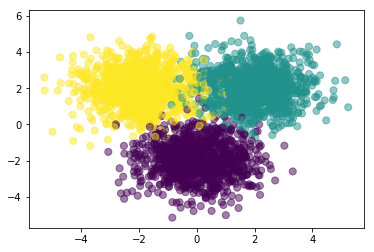

In [20]:
# Create a dataset with 3 catagories having 1000 samples each. Each sample is labeled with its catagory indicator.

# Number of samples per class
Nclass = 1000
np.random.seed(1)

X1 = np.random.randn(Nclass, 2) + np.array([0, -2]) # sift distribution center to (0, -2)
X2 = np.random.randn(Nclass, 2) + np.array([2, 2])  # sift distribution center to (2, 2)
X3 = np.random.randn(Nclass, 2) + np.array([-2, 2]) # sift distribution center to (-2, 2)
print("Shape of X1, X2, X3 respectively", X1.shape, X2.shape, X3.shape)

# Vertically stack these samples to create dataset of 1500 samples.
XX = np.vstack([X1, X2, X3])

# Populate labels for all samples
YY = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)
print("XX.shape =", XX.shape, ", YY.shape =", YY.shape)

Z = np.hstack( (XX, YY.reshape(XX.shape[0], 1)) ) # pass a tuple
# shuffle it
np.random.shuffle(Z)
print("Z.shape =", Z.shape)

# let's see what it looks like
plt.scatter(Z[:,0], Z[:,1], c=Z[:,2], s=50, alpha=0.5)
plt.show()


## Non-linear Activation Functions

In [21]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)


## Forward Propagation (Prediction)
Performance of a randomly initialized Neural Network on classifying this dataset

In [22]:
D = 2 # dimensionality of input
M = 3 # number of layers
K = 3 # number of classes

# randomly initialize weights
W1 = np.random.randn(D, M)
b1 = np.random.randn(M)
W2 = np.random.randn(M, K)
b2 = np.random.randn(K)


# Forward Propagation
def forward(X, W1, b1, W2, b2):
    F = X.dot(W1) + b1
    Z = sigmoid(F) # Non-linear activation function
    A = Z.dot(W2) + b2
    Y = softmax(A) # Use Softmax for more than two catagories
    return Y, Z

# get the data
X, Y = Z[:, :-1], Z[:, 2].astype(np.int32)

# Predict the classes for each sample in X
Yhat, _ = forward(X, W1, b1, W2, b2)
P = np.argmax(Yhat, axis=1)

# verify we chose the correct axis
assert(len(P) == len(Y))
print("Yhat[0:5] =\n", Yhat[0:5])
print(P[0:5])

# Determine the classification rate
# num correct / num total
def classification_accuracy(Y, P):
    n_correct = 0
    n_total = 0
    for i in range(len(Y)):
        n_total += 1
        if Y[i] == P[i]:
            n_correct += 1
    #print("correct/total =", n_correct, "/", n_total)
    return float(n_correct) / n_total


print("Classification accuracy for randomly chosen weights:", classification_accuracy(Y, P))


Yhat[0:5] =
 [[0.20490336 0.04324731 0.75184934]
 [0.12652405 0.10618678 0.76728917]
 [0.16954286 0.03816436 0.79229277]
 [0.22859925 0.05631708 0.71508367]
 [0.18696467 0.06234482 0.75069051]]
[2 2 2 2 2]
Classification accuracy for randomly chosen weights: 0.3333333333333333


## Back Propagation (Learning)
How Neural networks Learns - Example of logistic regressions with neural network.

cost: -4703.419921232554 	classification_rate: 0.3333333333333333
cost: -436.2494341767053 	classification_rate: 0.969
cost: -340.05223628385744 	classification_rate: 0.9703333333333334
cost: -306.59164091330695 	classification_rate: 0.9706666666666667
cost: -289.55620704400445 	classification_rate: 0.971
cost: -279.1933405008807 	classification_rate: 0.971
cost: -272.1846192160215 	classification_rate: 0.9703333333333334
cost: -267.10259242825003 	classification_rate: 0.971
cost: -263.2421888021895 	classification_rate: 0.9706666666666667
cost: -260.2193615263779 	classification_rate: 0.9703333333333334


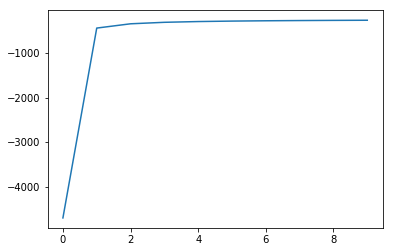

In [23]:
np.random.seed(1)

def derivative_w2(Z, T, Y):
    N, K = T.shape
    M = Z.shape[1] # H is (N, M)

    # # slow
    # ret1 = np.zeros((M, K))
    # for n in xrange(N):
    #     for m in xrange(M):
    #         for k in xrange(K):
    #             ret1[m,k] += (T[n,k] - Y[n,k])*Z[n,m]

    # # a bit faster - let's not loop over m
    # ret2 = np.zeros((M, K))
    # for n in xrange(N):
    #     for k in xrange(K):
    #         ret2[:,k] += (T[n,k]* - Y[n,k])*Z[n,:]

    # assert(np.abs(ret1 - ret2).sum() < 0.00001)

    # # even faster  - let's not loop over k either
    # ret3 = np.zeros((M, K))
    # for n in xrange(N): # slow way first
    #     ret3 += np.outer( Z[n], T[n] - Y[n] )

    # assert(np.abs(ret1 - ret3).sum() < 0.00001)

    # fastest - let's not loop over anything
    ret4 = Z.T.dot(T - Y)
    # assert(np.abs(ret1 - ret4).sum() < 0.00001)

    return ret4


def derivative_w1(X, Z, T, Y, W2):
    N, D = X.shape
    M, K = W2.shape

    # slow way first
    # ret1 = np.zeros((X.shape[1], M))
    # for n in xrange(N):
    #     for k in xrange(K):
    #         for m in xrange(M):
    #             for d in xrange(D):
    #                 ret1[d,m] += (T[n,k] - Y[n,k])*W2[m,k]*Z[n,m]*(1 - Z[n,m])*X[n,d]

    # fastest
    dZ = (T - Y).dot(W2.T) * Z * (1 - Z)
    ret2 = X.T.dot(dZ)

    # assert(np.abs(ret1 - ret2).sum() < 0.00001)

    return ret2


def derivative_b2(T, Y):
    return (T - Y).sum(axis=0)


def derivative_b1(T, Y, W2, Z):
    return ((T - Y).dot(W2.T) * Z * (1 - Z)).sum(axis=0)


def cost(T, Y):
    tot = T * np.log(Y)
    return tot.sum()

# Convert columar indicator vector to binary indicator matrix.
# Ex. Y = [2, 1, 0]
# return T = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
def conv_indicator_to_matrix(Y, numClasses):
    N = len(Y)
    T = np.zeros((N, numClasses))
    for i in range(N):
        T[i, Y[i]] = 1
    return T


# Use randomly initialized data X and its labels Y
N = len(Y)
# turn Y into an indicator matrix for training
T = conv_indicator_to_matrix(Y, K)

# randomly initialize weights of the model
W1 = np.random.randn(D, M)
b1 = np.random.randn(M)
W2 = np.random.randn(M, K)
b2 = np.random.randn(K)
learning_rate = 2e-4

costs = []
for epoch in range(1000):
    output, hidden = forward(X, W1, b1, W2, b2)
    # this is gradient ASCENT, not DESCENT
    # be comfortable with both!
    # Whether to assend or decend, depends upon cost function.
    # oldW2 = W2.copy()
    W2 += learning_rate * derivative_w2(hidden, T, output)
    b2 += learning_rate * derivative_b2(T, output)
    W1 += learning_rate * derivative_w1(X, hidden, T, output, W2)
    b1 += learning_rate * derivative_b1(T, output, W2, hidden)
    
    # Print the stats (cost and accuracy)
    if epoch % 100 == 0:
        c = cost(T, output)
        P = np.argmax(output, axis=1)
        r = classification_accuracy(Y, P)
        print("cost:", c, "\tclassification_rate:", r)
        costs.append(c)


plt.plot(costs)
plt.show()



## Linear regressions with Deep neural network
### Generate saddle shape data

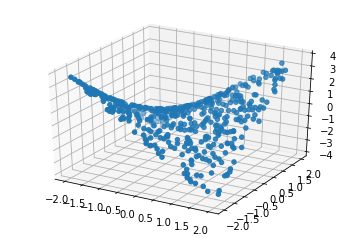

In [24]:
from mpl_toolkits.mplot3d import Axes3D

# generate and plot the data
N = 500
X = np.random.random((N, 2))*4 - 2 # in between (-2, +2)
Y = X[:,0]*X[:,1] # makes a saddle shape data - labels

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)
plt.show()

### Prediction and Learning - Forward and Back Propagatoion

How Neural networks Learns - Example of linear regressions with neural network.

3.5986166063408707
0.07716107814987981
0.07516814880710129
0.07428197492004236
0.0735694377490394
0.07298285730409312
0.07248460853671561
0.07207012752665347


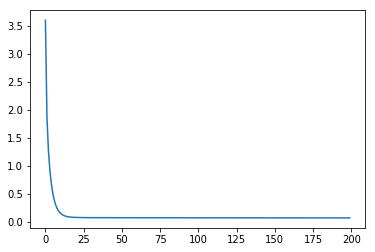

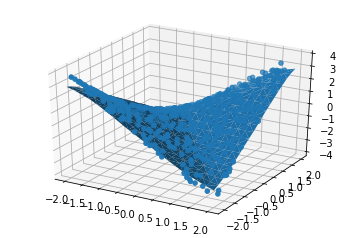

In [25]:
# make a neural network and train it
D = 2
M = 100 # number of hidden units

# randomly initialize weights of the model
# layer 1
W = np.random.randn(D, M) / np.sqrt(D)
b = np.zeros(M)
# layer 2
V = np.random.randn(M) / np.sqrt(M)
c = 0


# Compute the output or prediction
# consider the params global
def forward(X):
  Z = X.dot(W) + b
  Z = Z * (Z > 0) # relu
  # Z = np.tanh(Z)

  Yhat = Z.dot(V) + c
  return Z, Yhat



# how to train the params / compute derivatives
def derivative_V(Z, Y, Yhat):
  return (Y - Yhat).dot(Z)

def derivative_c(Y, Yhat):
  return (Y - Yhat).sum()

def derivative_W(X, Z, Y, Yhat, V):
  # dZ = np.outer(Y - Yhat, V) * (1 - Z * Z) # this is for tanh activation
  dZ = np.outer(Y - Yhat, V) * (Z > 0) # relu
  return X.T.dot(dZ)

def derivative_b(Z, Y, Yhat, V):
  # dZ = np.outer(Y - Yhat, V) * (1 - Z * Z) # this is for tanh activation
  dZ = np.outer(Y - Yhat, V) * (Z > 0) # this is for relu activation
  return dZ.sum(axis=0)

# Function to update weight with learning rate for next iteration
def update(X, Z, Y, Yhat, W, b, V, c, learning_rate=1e-4):
  gV = derivative_V(Z, Y, Yhat)
  gc = derivative_c(Y, Yhat)
  gW = derivative_W(X, Z, Y, Yhat, V)
  gb = derivative_b(Z, Y, Yhat, V)

  V += learning_rate*gV
  c += learning_rate*gc
  W += learning_rate*gW
  b += learning_rate*gb

  return W, b, V, c




# so we can plot the costs later
def get_cost(Y, Yhat):
  return ((Y - Yhat)**2).mean()



# run a training loop
# plot the costs
# and plot the final result
costs = []
for i in range(200):
  Z, Yhat = forward(X)
  W, b, V, c = update(X, Z, Y, Yhat, W, b, V, c)
  cost = get_cost(Y, Yhat)
  costs.append(cost)
  if i % 25 == 0:
    print(cost)

# plot the costs
plt.plot(costs)
plt.show()

# plot the prediction with the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)

# surface plot
line = np.linspace(-2, 2, 20)
xx, yy = np.meshgrid(line, line)
Xgrid = np.vstack((xx.flatten(), yy.flatten())).T
_, Yhat = forward(Xgrid)
ax.plot_trisurf(Xgrid[:,0], Xgrid[:,1], Yhat, linewidth=0.2, antialiased=True)
plt.show()


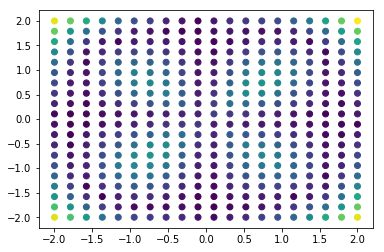

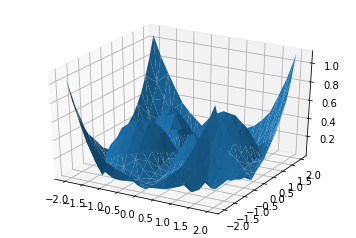

In [26]:
# plot magnitude of residuals
Ygrid = Xgrid[:,0]*Xgrid[:,1]
R = np.abs(Ygrid - Yhat)

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=R)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(Xgrid[:,0], Xgrid[:,1], R, linewidth=0.2, antialiased=True)
plt.show()

